In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn import metrics

# Data Acquisition

In [2]:
df = pd.read_csv ('https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv')
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,...,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,...,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,...,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


In [3]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [4]:
df.shape

(221738, 40)

In [5]:
# drop columns with no prediciton value. 
df.drop(['X','Y', 'LOCATION', 'INCDTTM', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'SDOTCOLNUM', 'PEDROWNOTGRNT',  'INCDATE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'ADDRTYPE', 'JUNCTIONTYPE'], axis = 1,inplace=True)

# Data Cleanup

In [6]:
# count total accidents grouped by severity. 
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    137776
Injury Collision                   58842
Unknown                            21657
Serious Injury Collision            3111
Fatality Collision                   352
Name: SEVERITYDESC, dtype: int64

In [7]:
# drop "Unknown" rows for severity and format to integer 
df['SEVERITYCODE'].replace("0", np.nan, inplace = True)
df.dropna(subset=['SEVERITYCODE'], axis=0, inplace = True)
df['SEVERITYCODE'].replace("1", 1, inplace = True)
df['SEVERITYCODE'].replace("2", 2, inplace = True)
df['SEVERITYCODE'].replace("3", 4, inplace = True)
df['SEVERITYCODE'].replace("2b", 3, inplace = True)
df['SEVERITYCODE'].astype(int)
df.shape

(200081, 10)

In [8]:
df['SEVERITYCODE'].value_counts()

1    137776
2     58842
3      3111
4       352
Name: SEVERITYCODE, dtype: int64

### Format categorical into dummy variables

In [9]:
df['SPEEDING'].replace(np.nan, 0, inplace = True)
df['SPEEDING'].replace("Y", 1, inplace = True)
df['SPEEDING'].astype(int)
df['SPEEDING'].unique()

array([0, 1])

In [10]:
df['PEDCYLCOUNT'].replace(2, 1, inplace = True)
df.rename(columns={'PEDCYLCOUNT': 'CYCLIST'}, inplace=True)
df['CYCLIST'].astype(int)
df['CYCLIST'].unique()

array([0, 1])

In [11]:
df['INATTENTIONIND'].replace(np.nan, 0, inplace = True)
df['INATTENTIONIND'].replace("Y", 1, inplace = True)
df['INATTENTIONIND'].astype(int)
df['INATTENTIONIND'].unique()

array([0, 1])

In [12]:
df['PEDCOUNT'].replace(2, 1, inplace = True)
df['PEDCOUNT'].replace(3, 1, inplace = True)
df['PEDCOUNT'].replace(4, 1, inplace = True)
df['PEDCOUNT'].replace(5, 1, inplace = True)
df['PEDCOUNT'].replace(6, 1, inplace = True)
df.rename(columns={'PEDCOUNT': 'PEDESTRIAN'}, inplace=True)
df['PEDESTRIAN'].astype(int)
df['PEDESTRIAN'].unique()

array([0, 1])

In [13]:
df['UNDERINFL'].replace(np.nan, 0, inplace = True)
df['UNDERINFL'].replace("Y", 1, inplace = True)
df['UNDERINFL'].replace("N", 0, inplace = True)
df['UNDERINFL'].replace("1", 1, inplace = True)
df['UNDERINFL'].replace("0", 0, inplace = True)
df['UNDERINFL'].astype(int)
df['UNDERINFL'].unique()

array([0, 1])

In [14]:
df['WEATHER'].replace('Unknown', np.nan, inplace = True)
df['WEATHER'].replace('Other', np.nan, inplace = True)
df['WEATHER'].replace('Raining', 'Rain', inplace = True)
df['WEATHER'].replace('Snowing', 'Snow', inplace = True)
df['WEATHER'].replace('Sleet/Hail/Freezing Rain', 'Hail', inplace = True)
df['WEATHER'].replace('Blowing Sand/Dirt', 'Blowing_Dirt', inplace = True)
df['WEATHER'].replace('Severe Crosswind', 'Crosswind', inplace = True)
df['WEATHER'].replace('Fog/Smog/Smoke', 'Fog', inplace = True)
df['WEATHER'].replace('Partly Cloudy', 'Cloudy', inplace = True)
df['WEATHER'].replace('Blowing Snow', 'Snow', inplace = True)
df['WEATHER'].unique()

array(['Clear', 'Rain', 'Overcast', nan, 'Snow', 'Hail', 'Fog',
       'Blowing_Dirt', 'Crosswind', 'Cloudy'], dtype=object)

In [15]:
df['ROADCOND'].replace('Unknown', np.nan, inplace = True)
df['ROADCOND'].replace('Other', np.nan, inplace = True)
df['ROADCOND'].replace('Snow/Slush', 'Ice', inplace = True)
df['ROADCOND'].replace('Snow', 'Ice', inplace = True)
df['ROADCOND'].replace('Standing Water', 'Standing_Water', inplace = True)
df['ROADCOND'].replace('Sand/Mud/Dirt', 'Mud', inplace = True)
df['ROADCOND'].unique()

array(['Dry', 'Wet', 'Ice', nan, 'Standing_Water', 'Mud', 'Oil'],
      dtype=object)

In [16]:
df['LIGHTCOND'].replace('Unknown', np.nan, inplace = True)
df['LIGHTCOND'].replace('Other', np.nan, inplace = True)
df['LIGHTCOND'].replace('Dark - Street Lights On', 'Dark_Street_Lights_On', inplace = True)
df['LIGHTCOND'].replace('Dark - No Street Lights', 'Dark_No_Street_Lights', inplace = True)
df['LIGHTCOND'].replace('Dark - Street Lights Off', 'Dark_No_Street_Lights', inplace = True)
df['LIGHTCOND'].replace('Dark - Unknown Lighting', 'Dark_Unknown_Lighting', inplace = True)
df.rename(columns={'LIGHTCOND': 'light'}, inplace=True)
df['light'].unique()

array(['Daylight', 'Dusk', 'Dark_Street_Lights_On', nan, 'Dawn',
       'Dark_No_Street_Lights', 'Dark_Unknown_Lighting'], dtype=object)

In [17]:
df.head()

,SEVERITYCODE,SEVERITYDESC,PEDESTRIAN,CYCLIST,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,light,SPEEDING
0,1,Property Damage Only Collision,0,0,0,0,Clear,Dry,Daylight,0
1,1,Property Damage Only Collision,0,0,1,0,Rain,Wet,Dusk,0
2,2,Injury Collision,0,0,0,0,Clear,Dry,Dark_Street_Lights_On,0
3,2,Injury Collision,1,0,0,0,Rain,Wet,Dark_Street_Lights_On,0
4,2,Injury Collision,0,0,0,0,Clear,Ice,Dark_Street_Lights_On,1


# Balancing the Dataset

In [18]:
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    137776
Injury Collision                   58842
Serious Injury Collision            3111
Fatality Collision                   352
Name: SEVERITYDESC, dtype: int64

In [19]:
# downsampeling "Property Damage Only Collision" and "Injury Collision"
df_damage = df[df.SEVERITYCODE==1]
df_injury = df[df.SEVERITYCODE==2]
df_damage_downsampled = resample(df_damage, replace=False, n_samples=3111, random_state=123)
df_injury_downsampled = resample(df_injury, replace=False, n_samples=3111, random_state=123)
df_downsampled = pd.concat([df_damage_downsampled, df_injury_downsampled])

In [20]:
# upsampeling "Fatality Collision"
df_fatalities = df[df.SEVERITYCODE==4]
df_serious = df[df.SEVERITYCODE==3]
df_fatalities_upsampled = resample(df_fatalities, replace=True, n_samples=3111,random_state=123)
df_balanced = pd.concat([df_downsampled, df_serious, df_fatalities_upsampled])

In [21]:
df_balanced['SEVERITYDESC'].value_counts()

Fatality Collision                3111
Serious Injury Collision          3111
Property Damage Only Collision    3111
Injury Collision                  3111
Name: SEVERITYDESC, dtype: int64

# Exploratory Data Analysis

In [22]:
# Exloring the feature Inattention
df_inattention = df_balanced[df_balanced.INATTENTIONIND==1]
inattention_count = pd.DataFrame(df_inattention.SEVERITYDESC.value_counts(normalize=True) * 100)
inattention_count.rename(columns={'SEVERITYDESC': 'Driver inattentive'}, inplace=True)

df_attention = df_balanced[df_balanced.INATTENTIONIND==0]
attention_count = pd.DataFrame(df_attention.SEVERITYDESC.value_counts(normalize=True) * 100)
attention_count.rename(columns={'SEVERITYDESC': 'Driver alert'}, inplace=True)

order = ['Property Damage Only Collision', 'Injury Collision', 'Serious Injury Collision', 'Fatality Collision']
df_a = pd.concat([inattention_count, attention_count], axis=1, join='inner').sort_index()
df_a.loc[order].round(1)

,Driver inattentive,Driver alert
Property Damage Only Collision,27.9,24.6
Injury Collision,37.6,23.3
Serious Injury Collision,24.1,25.1
Fatality Collision,10.4,27.0


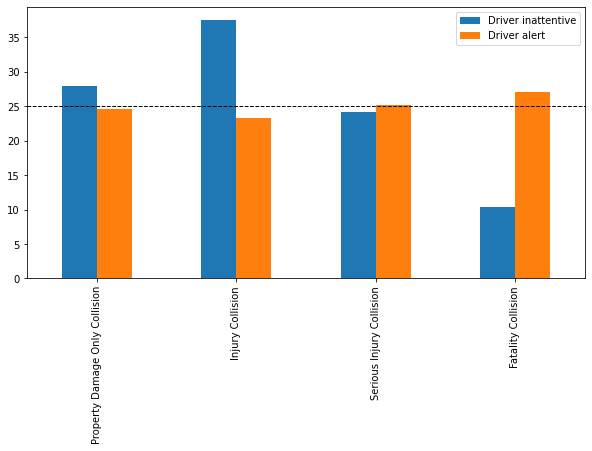

In [23]:
df_a.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [24]:
# Exloring the feature Under Influence 
df_drunk = df_balanced[df_balanced.UNDERINFL==1]
drunk_count = pd.DataFrame(df_drunk.SEVERITYDESC.value_counts(normalize=True) * 100)
drunk_count.rename(columns={'SEVERITYDESC': 'Driver under influence'}, inplace=True)

df_sober = df_balanced[df_balanced.UNDERINFL==0]
sober_count = pd.DataFrame(df_sober.SEVERITYDESC.value_counts(normalize=True) * 100)
sober_count.rename(columns={'SEVERITYDESC': 'Driver sober'}, inplace=True)

df_d = pd.concat([drunk_count, sober_count], axis=1, join='inner')
df_d.loc[order].round(1)

,Driver under influence,Driver sober
Property Damage Only Collision,8.0,27.4
Injury Collision,13.5,26.6
Serious Injury Collision,27.0,24.7
Fatality Collision,51.6,21.3


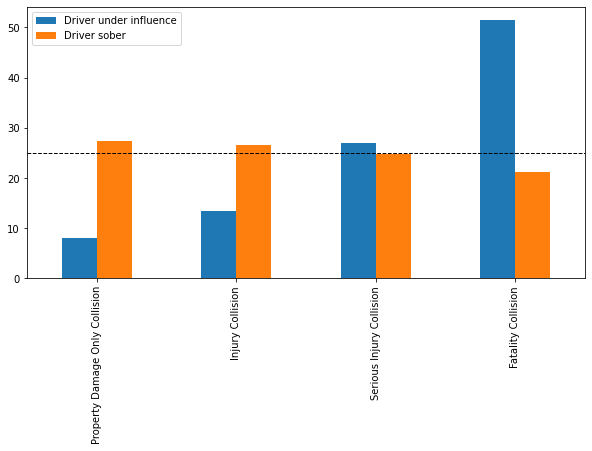

In [25]:
df_d.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [26]:
#Exloring the feature Cyclist Involvment
df_cyclist = df_balanced[df_balanced.CYCLIST==1]
cyclist_count = pd.DataFrame(df_cyclist.SEVERITYDESC.value_counts(normalize=True) * 100)
cyclist_count.rename(columns={'SEVERITYDESC': 'Cyclist involved'}, inplace=True)

df_no_cyclist = df_balanced[df_balanced.CYCLIST==0]
no_cyclist_count = pd.DataFrame(df_no_cyclist.SEVERITYDESC.value_counts(normalize=True) * 100)
no_cyclist_count.rename(columns={'SEVERITYDESC': 'No Cyclist involved'}, inplace=True)

df_c = pd.concat([cyclist_count, no_cyclist_count], axis=1, join='inner')
df_c.loc[order].round(1)

,Cyclist involved,No Cyclist involved
Property Damage Only Collision,2.1,26.9
Injury Collision,27.5,24.8
Serious Injury Collision,45.2,23.3
Fatality Collision,25.1,25.0


In [ ]:
df_c.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [27]:
# Exploring feature Pedestrian Involvment
df_pedestrian = df_balanced[df_balanced.PEDESTRIAN==1]
pedestrian_count = pd.DataFrame(df_pedestrian.SEVERITYDESC.value_counts(normalize=True) * 100)
pedestrian_count.rename(columns={'SEVERITYDESC': 'Pedestrian involved'}, inplace=True)

df_no_pedestrian = df_balanced[df_balanced.PEDESTRIAN==0]
no_pedestrian_count = pd.DataFrame(df_no_pedestrian.SEVERITYDESC.value_counts(normalize=True) * 100)
no_pedestrian_count.rename(columns={'SEVERITYDESC': 'No Pedestrian involved'}, inplace=True)

df_p = pd.concat([pedestrian_count, no_pedestrian_count], axis=1, join='inner')
df_p.loc[order].round(1)

,Pedestrian involved,No Pedestrian involved
Property Damage Only Collision,0.9,31.0
Injury Collision,12.9,28.0
Serious Injury Collision,36.8,22.0
Fatality Collision,49.4,18.9


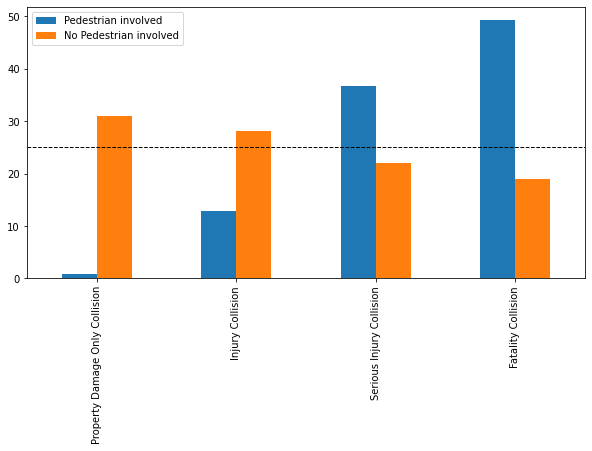

In [28]:
df_p.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [29]:
# Exloring the feature Speeding
df_speeding = df_balanced[df_balanced.SPEEDING==1]
speeding_count = pd.DataFrame(df_speeding.SEVERITYDESC.value_counts(normalize=True) * 100)
speeding_count.rename(columns={'SEVERITYDESC': 'Driver was speeding'}, inplace=True)

df_not_speeding = df_balanced[df_balanced.SPEEDING==0]
not_speeding_count = pd.DataFrame(df_not_speeding.SEVERITYDESC.value_counts(normalize=True) * 100)
not_speeding_count.rename(columns={'SEVERITYDESC': 'Driver was not speeding'}, inplace=True)

df_s = pd.concat([speeding_count, not_speeding_count], axis=1, join='inner')
df_s.loc[order].round(1)

,Driver was speeding,Driver was not speeding
Property Damage Only Collision,9.3,27.1
Injury Collision,11.3,26.9
Serious Injury Collision,25.4,24.9
Fatality Collision,54.0,21.1


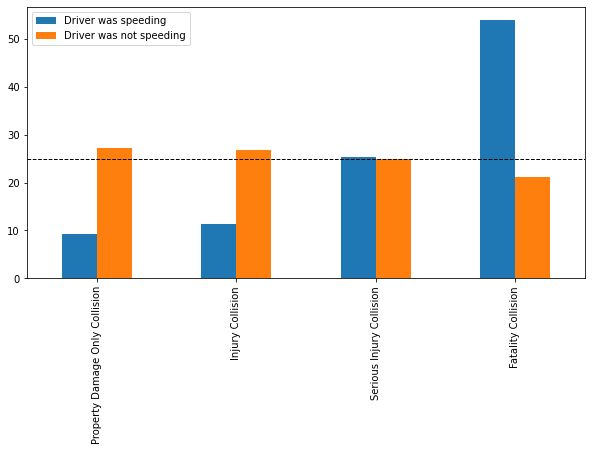

In [30]:
df_s.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [31]:
df_inattention = df_balanced[df_balanced.INATTENTIONIND==1]
inattention_count = pd.DataFrame(df_inattention.SEVERITYDESC.value_counts(normalize=True) * 100)
inattention_count.rename(columns={'SEVERITYDESC': 'Inattention'}, inplace=True)

df_drunk = df_balanced[df_balanced.UNDERINFL==1]
drunk_count = pd.DataFrame(df_drunk.SEVERITYDESC.value_counts(normalize=True) * 100)
drunk_count.rename(columns={'SEVERITYDESC': 'Underinfl'}, inplace=True)

df_cyclist = df_balanced[df_balanced.CYCLIST==1]
cyclist_count = pd.DataFrame(df_cyclist.SEVERITYDESC.value_counts(normalize=True) * 100)
cyclist_count.rename(columns={'SEVERITYDESC': 'Cyclist'}, inplace=True)

df_pedestrian = df_balanced[df_balanced.PEDESTRIAN==1]
pedestrian_count = pd.DataFrame(df_pedestrian.SEVERITYDESC.value_counts(normalize=True) * 100)
pedestrian_count.rename(columns={'SEVERITYDESC': 'Pedestrian'}, inplace=True)

df_speeding = df_balanced[df_balanced.SPEEDING==1]
speeding_count = pd.DataFrame(df_speeding.SEVERITYDESC.value_counts(normalize=True) * 100)
speeding_count.rename(columns={'SEVERITYDESC': 'Speeding'}, inplace=True)

df_counted = pd.concat([drunk_count, inattention_count, cyclist_count, pedestrian_count, speeding_count], axis=1, join='inner')
df_counted.loc[order].round(1)

,Underinfl,Inattention,Cyclist,Pedestrian,Speeding
Property Damage Only Collision,8.0,27.9,2.1,0.9,9.3
Injury Collision,13.5,37.6,27.5,12.9,11.3
Serious Injury Collision,27.0,24.1,45.2,36.8,25.4
Fatality Collision,51.6,10.4,25.1,49.4,54.0


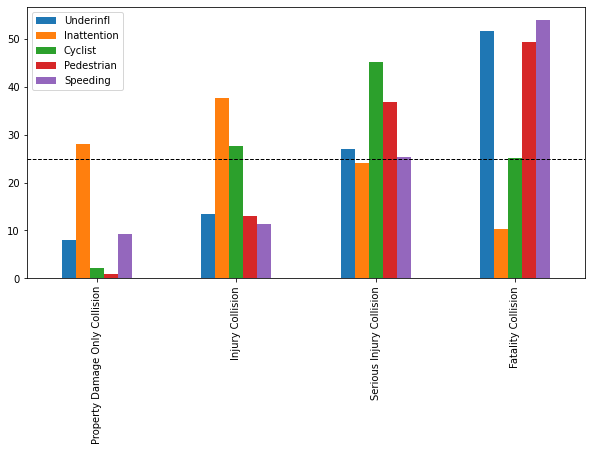

In [32]:
df_counted.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [33]:
df_balanced['WEATHER'].value_counts()

Clear        7610
Rain         2109
Overcast     1800
Fog            49
Snow           35
Cloudy         11
Crosswind       9
Hail            5
Name: WEATHER, dtype: int64

In [51]:
df_w = pd.get_dummies(df_balanced, columns=['WEATHER'])

df_rain = df_w[df_w.WEATHER_Rain==1]
rain_count = pd.DataFrame(df_rain.SEVERITYDESC.value_counts(normalize=True) * 100)
rain_count.rename(columns={'SEVERITYDESC': 'Rain'}, inplace=True)

df_overcast = df_w[df_w.WEATHER_Overcast==1]
overcast_count = pd.DataFrame(df_overcast.SEVERITYDESC.value_counts(normalize=True) * 100)
overcast_count.rename(columns={'SEVERITYDESC': 'Overcast'}, inplace=True)

df_clear = df_w[df_w.WEATHER_Clear==1]
clear_count = pd.DataFrame(df_clear.SEVERITYDESC.value_counts(normalize=True) * 100)
clear_count.rename(columns={'SEVERITYDESC': 'Clear'}, inplace=True)

df_fog = df_w[df_w.WEATHER_Fog==1]
fog_count = pd.DataFrame(df_fog.SEVERITYDESC.value_counts(normalize=True) * 100)
fog_count.rename(columns={'SEVERITYDESC': 'Fog'}, inplace=True)

df_weather = pd.concat([rain_count, overcast_count, clear_count, fog_count], axis=1, join='inner')
df_weather.loc[order].round(1)

,Rain,Overcast,Clear,Fog
Property Damage Only Collision,23.8,23.0,22.0,14.3
Injury Collision,28.7,25.8,25.0,32.7
Serious Injury Collision,25.1,24.8,26.6,6.1
Fatality Collision,22.4,26.4,26.4,46.9


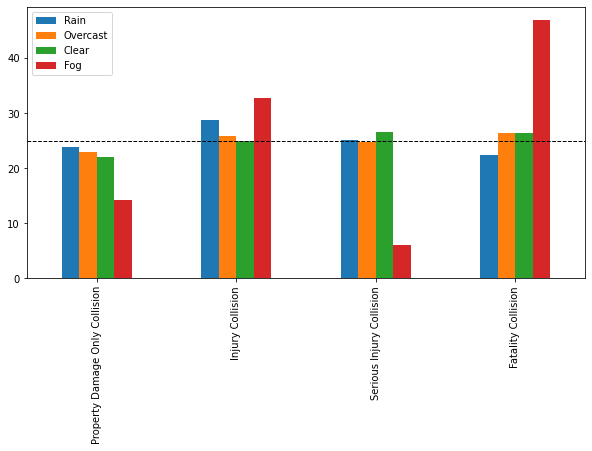

In [52]:
df_weather.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [57]:
df_balanced['ROADCOND'].value_counts()

Dry               8627
Wet               2964
Ice                101
Standing_Water       7
Mud                  2
Name: ROADCOND, dtype: int64

In [58]:
df_r = pd.get_dummies(df_balanced, columns=['ROADCOND'])

df_wet = df_r[df_r.ROADCOND_Wet==1]
wet_count = pd.DataFrame(df_wet.SEVERITYDESC.value_counts(normalize=True) * 100)
wet_count.rename(columns={'SEVERITYDESC': 'Wet'}, inplace=True)

df_dry = df_r[df_r.ROADCOND_Dry==1]
dry_count = pd.DataFrame(df_dry.SEVERITYDESC.value_counts(normalize=True) * 100)
dry_count.rename(columns={'SEVERITYDESC': 'Dry'}, inplace=True)

df_ice = df_r[df_r.ROADCOND_Ice==1]
ice_count = pd.DataFrame(df_ice.SEVERITYDESC.value_counts(normalize=True) * 100)
ice_count.rename(columns={'SEVERITYDESC': 'Ice'}, inplace=True)

df_road = pd.concat([wet_count, dry_count, ice_count], axis=1, join='inner')
df_road.round(1)

,Wet,Dry,Ice
Injury Collision,28.7,24.7,20.8
Serious Injury Collision,25.6,26.0,25.7
Property Damage Only Collision,24.2,21.8,45.5
Fatality Collision,21.5,27.5,7.9


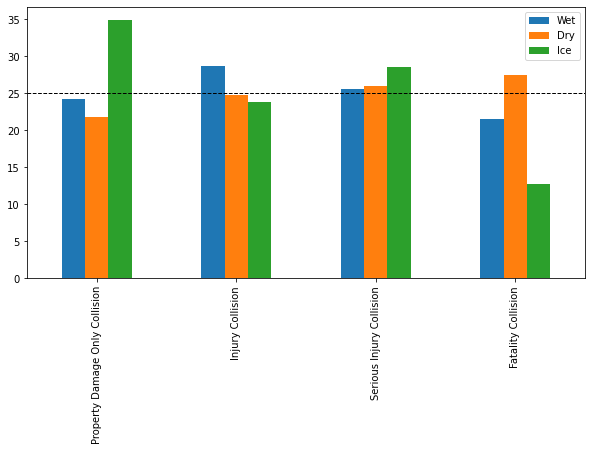

In [40]:
df_road.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [59]:
df_balanced['light'].value_counts()

Daylight                 7073
Dark_Street_Lights_On    3886
Dusk                      444
Dark_No_Street_Lights     181
Dawn                      180
Dark_Unknown_Lighting       1
Name: light, dtype: int64

In [62]:
df_l = pd.get_dummies(df_balanced, columns=['light'])

df_daylight = df_l[df_l.light_Daylight==1]
daylight_count = pd.DataFrame(df_daylight.SEVERITYDESC.value_counts(normalize=True) * 100)
daylight_count.rename(columns={'SEVERITYDESC': 'Daylight'}, inplace=True)

df_dark_lights = df_l[df_l.light_Dark_Street_Lights_On==1]
dark_lights_count = pd.DataFrame(df_dark_lights.SEVERITYDESC.value_counts(normalize=True) * 100)
dark_lights_count.rename(columns={'SEVERITYDESC': 'Dark with Street Lights'}, inplace=True)

df_dusk = df_l[df_l.light_Dusk==1]
dusk_count = pd.DataFrame(df_dusk.SEVERITYDESC.value_counts(normalize=True) * 100)
dusk_count.rename(columns={'SEVERITYDESC': 'Dusk'}, inplace=True)

df_dark_no_lights = df_l[df_l.light_Dark_No_Street_Lights==1]
dark_no_lights_count = pd.DataFrame(df_dark_no_lights.SEVERITYDESC.value_counts(normalize=True) * 100)
dark_no_lights_count.rename(columns={'SEVERITYDESC': 'Dark No Street Lights'}, inplace=True)

df_dawn = df_l[df_l.light_Dawn==1]
dawn_count = pd.DataFrame(df_dawn.SEVERITYDESC.value_counts(normalize=True) * 100)
dawn_count.rename(columns={'SEVERITYDESC': 'Dawn'}, inplace=True)

df_light = pd.concat([daylight_count, dark_lights_count, dusk_count, dark_no_lights_count, dawn_count], axis=1, join='inner')
df_light.loc[order].round(1)

,Daylight,Dark with Street Lights,Dusk,Dark No Street Lights,Dawn
Property Damage Only Collision,24.3,20.0,21.4,28.7,22.2
Injury Collision,29.1,20.0,26.8,16.0,20.0
Serious Injury Collision,25.3,26.2,24.8,29.3,33.3
Fatality Collision,21.3,33.7,27.0,26.0,24.4


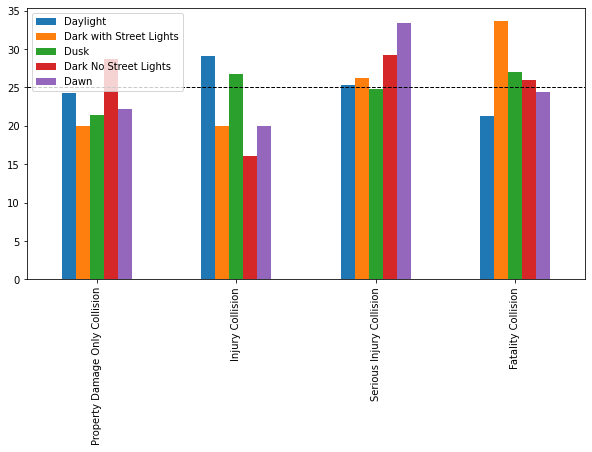

In [63]:
df_light.loc[order].plot(kind='bar', figsize=(10,5))
plt.axhline(y=25,linewidth=1, linestyle='--', color='k')

In [64]:
df_dummies = pd.get_dummies(df_balanced, columns = ['light', 'ROADCOND', 'WEATHER'])
df_dummies.columns

Index(['LOCATION', 'SEVERITYCODE', 'SEVERITYDESC', 'PEDESTRIAN', 'CYCLIST',
       'INCDTTM', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',
       'light_Dark_No_Street_Lights', 'light_Dark_Street_Lights_On',
       'light_Dark_Unknown_Lighting', 'light_Dawn', 'light_Daylight',
       'light_Dusk', 'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Mud',
       'ROADCOND_Standing_Water', 'ROADCOND_Wet', 'WEATHER_Clear',
       'WEATHER_Cloudy', 'WEATHER_Crosswind', 'WEATHER_Fog', 'WEATHER_Hail',
       'WEATHER_Overcast', 'WEATHER_Rain', 'WEATHER_Snow'],
      dtype='object')

# Training the Models

In [66]:
y = df_dummies['SEVERITYDESC'].values
X = df_dummies[['PEDESTRIAN', 'CYCLIST', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'light_Dark_No_Street_Lights', 'light_Dark_Street_Lights_On', 'light_Dark_Unknown_Lighting', 'light_Dawn', 'light_Daylight', 'light_Dusk', 'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Mud', 'ROADCOND_Standing_Water', 'ROADCOND_Wet', 'WEATHER_Clear', 'WEATHER_Cloudy', 'WEATHER_Crosswind', 'WEATHER_Fog', 'WEATHER_Hail', 'WEATHER_Overcast', 'WEATHER_Rain', 'WEATHER_Snow']].values

In [67]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (9955, 24) (9955,)
Test set: (2489, 24) (2489,)


### K-Nearest Neighbour

In [68]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.35194857, 0.37725994, 0.42788268, 0.41301728, 0.42547208,
       0.41181197, 0.42225793, 0.44676577, 0.44033748, 0.44395339,
       0.446364  , 0.43792688, 0.44395339, 0.44475693, 0.43792688,
       0.43631981, 0.4327039 , 0.4339092 , 0.43230213])

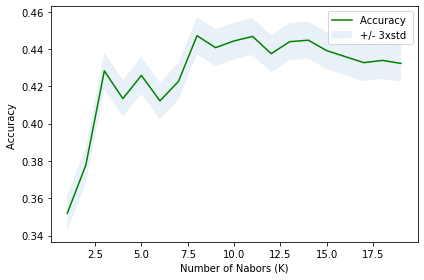

In [46]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [69]:
k = 8
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_neigh = neigh.predict(X_test)

### Decision Tree

In [70]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
drugTree.fit(X_train,y_train)
yhat_tree = drugTree.predict(X_test)

### Logistic Regression

In [71]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_lr = LR.predict(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Support Vector Machine

In [72]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train, y_train) 
yhat_svm = SVM.predict(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Evaluation

In [73]:
f1knn = f1_score(y_test, yhat_neigh, average='weighted')
print ('F1 Score KNN:', f1knn.round(2))
f1tree = f1_score(y_test, yhat_tree, average='weighted')
print ('F1 Score Tree:', f1tree.round(2))
f1lr = f1_score(y_test, yhat_lr, average='weighted')
print ('F1 Score LR:', f1lr.round(2))
f1svm = f1_score(y_test, yhat_svm, average='weighted')
print ('F1 Score SVM:', f1svm.round(2))

F1 Score KNN: 0.42
F1 Score Tree: 0.44
F1 Score LR: 0.43
F1 Score SVM: 0.4


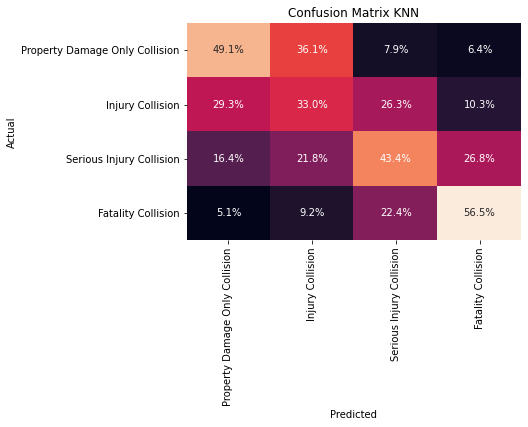

In [100]:
data = {'y_test' : y_test, 'yhat_neigh' : yhat_neigh}
df_cm = pd.DataFrame(data, columns=['y_test','yhat_neigh'])
confusion_matrix = pd.crosstab(df_cm['y_test'], df_cm['yhat_neigh'], rownames=['Actual'], colnames=['Predicted'], normalize='columns')
ax = plt.axes()
sns.heatmap(confusion_matrix[order].loc[order], annot=True, ax = ax, fmt=".1%", cbar=False)
ax.set_title('Confusion Matrix KNN')
plt.show()

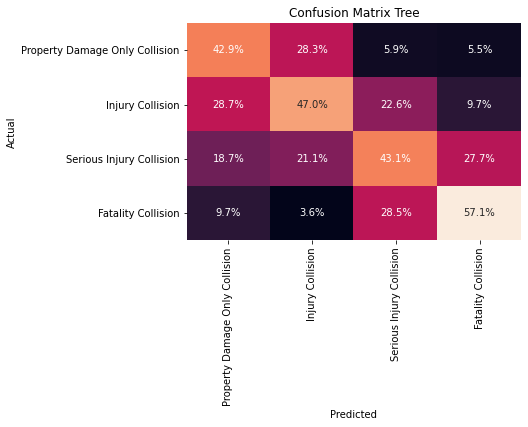

In [99]:
data = {'y_test' : y_test, 'yhat_tree' : yhat_tree}
df_cm = pd.DataFrame(data, columns=['y_test','yhat_tree'])
confusion_matrix = pd.crosstab(df_cm['y_test'], df_cm['yhat_tree'], rownames=['Actual'], colnames=['Predicted'], normalize='columns')
ax = plt.axes()
sns.heatmap(confusion_matrix[order].loc[order], annot=True, ax = ax, fmt=".1%", cbar=False)
ax.set_title('Confusion Matrix Tree')
plt.show()

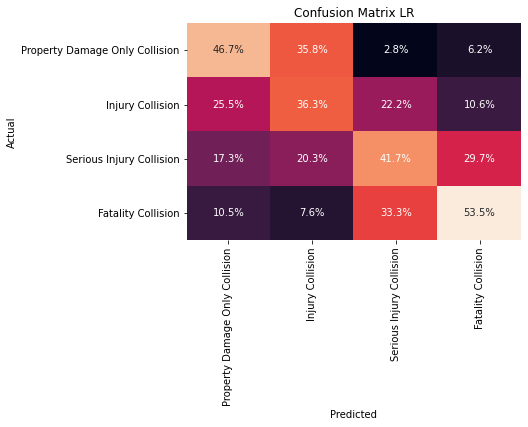

In [98]:
data = {'y_test' : y_test, 'yhat_lr' : yhat_lr}
df_cm = pd.DataFrame(data, columns=['y_test','yhat_lr'])
confusion_matrix = pd.crosstab(df_cm['y_test'], df_cm['yhat_lr'], rownames=['Actual'], colnames=['Predicted'], normalize='columns')
ax = plt.axes()
sns.heatmap(confusion_matrix[order].loc[order], annot=True, ax = ax, fmt=".1%", cbar=False)
ax.set_title('Confusion Matrix LR')
plt.show()

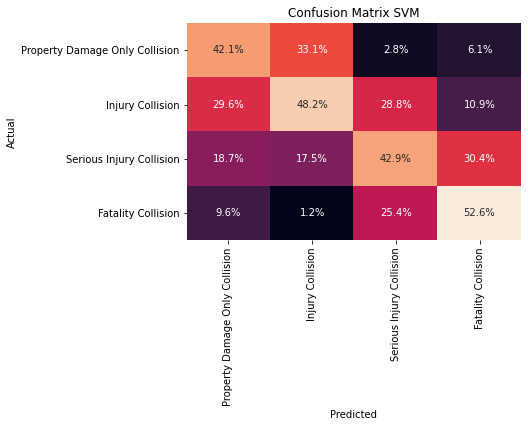

In [97]:
data = {'y_test' : y_test, 'yhat_svm' : yhat_svm}
df_cm = pd.DataFrame(data, columns=['y_test','yhat_svm'])
confusion_matrix = pd.crosstab(df_cm['y_test'], df_cm['yhat_svm'], rownames=['Actual'], colnames=['Predicted'], normalize='columns')
ax = plt.axes()
sns.heatmap(confusion_matrix[order].loc[order], annot=True, ax = ax, fmt=".1%", cbar=False)
ax.set_title('Confusion Matrix SVM')
plt.show()